In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [106]:
from sklearn.metrics import (precision_score, recall_score, roc_auc_score)

In [107]:
raw_data = pd.read_csv('../normalized_data.csv')

In [108]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
def encode_categorical(df, columnName):
    df[columnName] = labelencoder.fit_transform(df[columnName])
    return df

In [109]:
raw_data = encode_categorical(raw_data, 'bha_configuration')
raw_data = encode_categorical(raw_data, 'wellbore_category')
raw_data = encode_categorical(raw_data, 'packer_vs_tac')
raw_data = encode_categorical(raw_data, 'rod_sinker_type')
raw_data = encode_categorical(raw_data, 'manual_scale')
raw_data = encode_categorical(raw_data, 'rod_make')
raw_data = encode_categorical(raw_data, 'rod_apigrade')
raw_data = encode_categorical(raw_data, 'FAILURETYPE')

In [110]:
raw_data['FAILURETYPE'].value_counts()

2    152
1    152
0    152
Name: FAILURETYPE, dtype: int64

In [111]:
features = ['PrimarySetpoint','SecondarySetpoint','H2S_CONCENTRATION','StrokeLength','bha_configuration','max_unguided_dls','dls_high_in_hole','MAX_INCLINATION','AVG_PRESSURE_TUBING','AVG_PRESSURE_CASING','AVG_DIFFERENTIAL_PRESSURE','AVG_OIL_VOLUME','AVG_WATER_VOLUME','AVG_LIQUID_VOLUME','overall_max_sideload','shallow_max_sideload','max_unguided_sideload','wellbore_category','packer_vs_tac','rod_sinker_type','manual_scale','rod_has_guides','rod_apigrade']

In [112]:
X = np.array(raw_data[features])
# X = data in the form of an array
# use X to predict failure type (y)

In [113]:
y = np.array(raw_data['FAILURETYPE'])
# y = target variable

In [114]:
# divide our dataset into 4 different data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Build Basic Random Forest Model

In [115]:
rf_model = RandomForestClassifier()

In [116]:
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Check Accuracy

In [117]:
rf_model.score(X_train,y_train)
# the 1.0 shows that we have overfitted this training data, 
# which means it won't do well on the test data set

1.0

In [118]:
rf_model.score(X_test,y_test)

0.44565217391304346

### Important features

In [119]:
# prints out the features that the decision tree vonsiders as most important
# The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used.
fi_model = pd.DataFrame({'feature': features,
                   'importance': rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
12,AVG_WATER_VOLUME,0.100782
11,AVG_OIL_VOLUME,0.086358
13,AVG_LIQUID_VOLUME,0.081888
8,AVG_PRESSURE_TUBING,0.071601
9,AVG_PRESSURE_CASING,0.070996
10,AVG_DIFFERENTIAL_PRESSURE,0.066728
7,MAX_INCLINATION,0.064350
14,overall_max_sideload,0.062780
16,max_unguided_sideload,0.059303
15,shallow_max_sideload,0.055261


# Optimize Random Forest through Random Search

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best.

hyperparameters include the number of decision trees in the forest and the number of features considered by each tree when splitting a node

n_estimators = number of trees in the forest

max_features = max number of features considered for splitting a node

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node 

bootstrap = method for sampling data points (with or without replacement)

In [120]:
from sklearn.model_selection import RandomizedSearchCV

In [121]:
# Hyperparameter grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 4, stop = 10, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [122]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [123]:
rf_model = RandomForestClassifier()

In [124]:
from sklearn.model_selection import GridSearchCV
rf_grid = GridSearchCV(estimator = rf_model, param_grid = random_grid, cv = 3, verbose = 2, n_jobs = 4)

In [125]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 928 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 2552 tasks      | elapsed:   25.4s
[Parallel(n_jobs=4)]: Done 4816 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done 7736 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 11296 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 12960 out of 12960 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              random_state=None, verbose=0,
                                   

In [126]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 9}

In [127]:
rf_grid.score(X_train,y_train)

0.760989010989011

In [128]:
rf_grid.score(X_test,y_test)

0.44565217391304346

# Use Best Model

In [129]:
best_model = rf_grid.best_estimator_

features with low importance do not contribute much to the prediction of failure type

This means that we can remove this feature and train our random forest classifier again and then see if it can improve its performance on the test data.

In [130]:
b_model = pd.DataFrame({'feature': features,
                   'importance': best_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
b_model.head()

,feature,importance
13,AVG_LIQUID_VOLUME,0.130318
12,AVG_WATER_VOLUME,0.115898
7,MAX_INCLINATION,0.103238
6,dls_high_in_hole,0.083345
10,AVG_DIFFERENTIAL_PRESSURE,0.081721


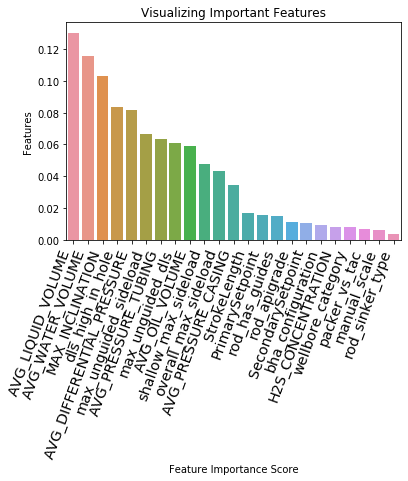

In [131]:
# visualize important features

sns.barplot(x=b_model.feature, y=b_model.importance)

plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.xticks(
    rotation=70, horizontalalignment="right", fontweight="light", fontsize="x-large"
)
plt.show()

# Random Forest Results

In [132]:
best_model.score(X_train,y_train)

0.760989010989011

In [133]:
rf_grid.score(X_test,y_test)

0.44565217391304346

In [134]:
rf_predictions = best_model.predict(X_test)

In [137]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

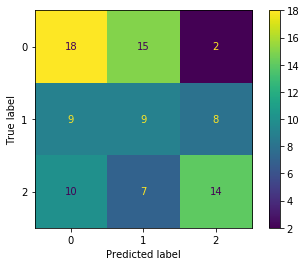

In [148]:
cm = confusion_matrix(y_test, rf_predictions)
plotRF = plot_confusion_matrix(best_model, X_test,y_test)